# Twitter Sentiment Analysis - Feed-forward Neural Networks 
## <div> Vassilis Panagakis </div>

In [ ]:
!pip install d2l==0.15.0

In [ ]:
import pandas as pd
import numpy as np 
import re
import warnings
import torch
import matplotlib.pyplot as plt
import pickle

warnings.filterwarnings('ignore')  

## Load Data

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Create a dataframe from SentimentTweets.csv file data

In [ ]:
df=pd.read_csv('gdrive/My Drive/Colab Notebooks/SentimentTweets.csv', usecols=['target','id','date','flag','user','text'])

df.head()

,target,id,date,flag,user,text
0,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


In [ ]:
df.drop(columns=['id', 'date', 'flag', 'user'], axis=1, inplace=True) #drop useless columns

df.head()

,target,text
0,0,#brokenpromises...
1,0,David Carradine so sad. Thai's law not sure i...
2,4,A @ 415 B @ 425. Tell your bro i say congrats!
3,4,@littlefluffycat Indeed.
4,4,Completed Race 4 Life in 58mins with girlies f...


In [ ]:
# split 'target' and 'text' columns 
X = df[['text']]
y = df[['target']]

In [ ]:
from sklearn.model_selection import train_test_split

# get train and test dataframes 
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.2, stratify=df['target'], random_state = 42)

#### Display train and test sets after split

In [ ]:
train_X.head()

,text
492660,The respected journalist @robfahey just tried ...
858754,"@maggienash Thanks, Maggie. I'm still bouncing"
746070,"@do0dlebugdebz not now,but will be if you're o..."
885531,@Pure798 yea that works...ughh
806384,@melapoo lol Cool. I keep getting the weird on...


In [ ]:
test_X.head()

,text
220479,...... fuck you soderling. fuck you. this has ...
840623,OK next step - today I learn to twitter from m...
772674,trying to upload a picture and loves how twitt...
1037193,@addictedtonye Get 100 followers a day using w...
971656,@AmeliaBt It sure is..


## Labels Pre-processing

In [ ]:
# replace 4 with 1 to create binary labels
train_Y = train_Y.replace(4,1)
test_Y = test_Y.replace(4,1)

# create numpy arrays for sets' labels
train_y = np.asarray(train_Y['target'].tolist()) 
test_y = np.asarray(test_Y['target'].tolist())

# covert numpy arrays to torch tensors
train_y, test_y = map(torch.tensor, (train_y, test_y))
# covert tensors data to float
train_y, test_y = train_y.float(), test_y.float()

## Data Pre-processing

#### Load cleansed data from csv


In [ ]:
# restore processed data
train_X = pd.read_csv('gdrive/My Drive/Colab Notebooks/CleanedTrain.csv', usecols=['text','processedText'])
test_X = pd.read_csv('gdrive/My Drive/Colab Notebooks/CleanedTest.csv', usecols=['text','processedText'])

### Cleanse data

In [ ]:
# function that removes all @mentions, links and non alphabetic strings 
def clean_content(text):
    
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # remove text with @ prefix
    text = re.sub(r'http\S+', '', text) # remove text with http prefix (links)  
    text = re.sub(r'www\S+', '', text) # remove text with www prefix (links)
    text = re.sub(r'\\\w+', '', str(text)) # remove text after backslash
    text = re.sub(r'\b\w{1,2}\b', '', text) # remove text containing 2 or less characters
    
    text =  ''.join(ch for ch in text if ch.isalpha() or ch == ' ')
    
    text = text.lower() # convert text into lowercase
    
    return text

In [ ]:
# create a column for each set containing the processed text data
for index, row in train_X.iterrows():
    train_X.loc[index,'processedText'] = clean_content(train_X.loc[index,'text'])

for index, row in test_X.iterrows():
    test_X.loc[index,'processedText'] = clean_content(test_X.loc[index,'text'])

#### Display train and test sets after text cleansing

In [ ]:
train_X.head()

,text,processedText
492660,The respected journalist @robfahey just tried ...,the respected journalist just tried have sex...
858754,"@maggienash Thanks, Maggie. I'm still bouncing",thanks maggie still bouncing
746070,"@do0dlebugdebz not now,but will be if you're o...",not nowbut will you just sounded like da...
885531,@Pure798 yea that works...ughh,yea that worksughh
806384,@melapoo lol Cool. I keep getting the weird on...,lol cool keep getting the weird ones got th...


In [ ]:
test_X.head()

,text,processedText
220479,...... fuck you soderling. fuck you. this has ...,fuck you soderling fuck you this has night...
840623,OK next step - today I learn to twitter from m...,next step today learn twitter from phone ...
772674,trying to upload a picture and loves how twitt...,trying upload picture and loves how twitter ...
1037193,@addictedtonye Get 100 followers a day using w...,get followers day using once you add every...
971656,@AmeliaBt It sure is..,sure


In [ ]:
# # store processed data to a csv file
# train_X.to_csv('gdrive/My Drive/Colab Notebooks/CleanedTrain.csv', index = True, header=True)
# test_X.to_csv('gdrive/My Drive/Colab Notebooks/CleanedTest.csv', index = True, header=True)

### Tf-idf Vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfVectorizer = TfidfVectorizer(max_df=0.99, min_df=1, stop_words='english', max_features=150)

# apply tf-idf transformation to both train and test sets data
tr_tfidf = tfidfVectorizer.fit_transform(train_X['processedText'])
te_tfidf = tfidfVectorizer.transform(test_X['processedText'])

# insert transformed data to numpy arrays for both training and test sets
train_tfidf = tr_tfidf.toarray()
test_tfidf = te_tfidf.toarray()

#### Convert input vectors to torch tensors

In [ ]:
# covert numpy arrays to torch tensors
train_tfidf, test_tfidf = map(torch.tensor, (train_tfidf, test_tfidf))
# covert tensors data to float
train_tfidf, test_tfidf = train_tfidf.float(), test_tfidf.float()

### GloVe Pre-trained Embeddings

In [ ]:
from torchtext.data import Field 
from torchtext.vocab import GloVe

#### Load glove embeddings from disk

In [ ]:
with open('gdrive/My Drive/Colab Notebooks/train_glove.pkl', 'rb') as fp:
    train_glove = pickle.load(fp)

with open('gdrive/My Drive/Colab Notebooks/test_glove.pkl', 'rb') as fp:
    test_glove = pickle.load(fp)

#### Convert input vectors to torch tensors

In [ ]:
#covert numpy arrays to torch tensors
train_glove, test_glove = map(torch.tensor, (train_glove, test_glove))
# covert tensors data to float
train_glove, test_glove = train_glove.float(), test_glove.float()

### Produce embedding input vectors

In [ ]:
emb_size=100

embedding = GloVe(name='6B', dim=emb_size) # use "glove.6B.100d" as embedding

.vector_cache/glove.6B.zip: 862MB [06:51, 2.09MB/s]                           
 99%|█████████▉| 397903/400000 [00:16<00:00, 24948.78it/s]

In [ ]:
# function to tokenize preprocessed text and add the necessary padding tokens 
def tokenize(df, padding):

  text_field = Field(
      sequential=True,
      tokenize='spacy', 
      fix_length=padding,
      lower=True
  )

  label_field = Field(sequential=False, use_vocab=False)

  preprocessed_text = df['processedText'].apply(
      lambda x: text_field.preprocess(x)
  )

  return preprocessed_text

In [ ]:
# function that creates a mean vector for a series of tokens
def tokens_to_vector(tokens, embedding, emb_size):
  vectors = []
  
  for token in tokens:
    try: 
        vectors.append(embedding[token].cpu().detach().numpy()) # add word's vector to list if word belongs to embedding dictionary
    except KeyError:
        vectors.append(np.zeros(emb_size).astype('float32') ) # else, add a zero vector to the list to represent unknown words
          
  total = np.zeros(emb_size).astype('float32') 
  
  # compute the mean vector
  for v in vectors: 
      total += v
      
  mean = total / len(vectors)

  return mean.tolist() # return vector in list format

In [ ]:
padding = train_X.processedText.map(lambda x: len(x)).max() # find the largest 'processedText' in dataframe to determine the padding's length

In [ ]:
# apply tokenization to both train and test sets
train_toks = tokenize(train_X, padding)
test_toks = tokenize(test_X, padding)

 99%|█████████▉| 397903/400000 [00:30<00:00, 24948.78it/s]

In [ ]:
tr_glove = [] 

# create a list of vectors for every series of tokens in train set
for i, tokens in enumerate(train_toks):
  tr_glove.append(tokens_to_vector(tokens, embedding, 100))

te_glove = []

# create a list of vectors for every series of tokens in test set
for i, tokens in enumerate(test_toks):
  te_glove.append(tokens_to_vector(tokens, embedding, 100))

In [ ]:
# convert list of vectors to numpy array
train_glove = np.array(tr_glove)
test_glove = np.array(te_glove)

In [ ]:
# # store glove embeddings to disk
# with open('gdrive/My Drive/Colab Notebooks/train_glove.pkl', 'wb') as fp:
#     pickle.dump(train_glove, fp)

# with open('gdrive/My Drive/Colab Notebooks/test_glove.pkl', 'wb') as fp:
#     pickle.dump(test_glove, fp)

#### Convert input vectors to torch tensors

In [ ]:
#covert numpy arrays to torch tensors
train_glove, test_glove = map(torch.tensor, (train_glove, test_glove))
# covert tensors data to float
train_glove, test_glove = train_glove.float(), test_glove.float()

## Feed-Forward Neural Networks

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

### Evaluation Functions

In [ ]:
# function that creates a dataframe to display a user-given field of the Neural Networks
def display_func(net1, net2, net3, net4, column):
  nn_dic = {net1:['-'], net2:['-'], net3:['-'], net4:['-']}
  nn_df = pd.DataFrame.from_dict(nn_dic, orient='index', columns=[column])

  return nn_df

# function that creates a dataframe to display the Precision, Recall and F1-score of the Neural Networks
def display_metrics(tfidf, glove):
  nn_dic = {tfidf:['-','-','-'], glove:['-','-','-']}
  nn_df = pd.DataFrame.from_dict(nn_dic, orient='index', columns=['Precision','Recall','F1-Score'])

  return nn_df

# function that implements Root Mean Square Error
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat - y) ** 2))

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# function to plot loss per epoch
def loss_per_epoch(loss, title):
  plt.figure(figsize=(8, 5))
  plt.style.use('seaborn-whitegrid')

  plt.plot(range(len(loss)), loss)
  plt.title('Loss - Epoch Diagram (' + title + ')', size=20)
  plt.xlim=[1, len(loss)]
  plt.xlabel('Epochs', size=20)

  plt.yticks(loss, [i for i in loss])
  plt.yscale('logit')
  plt.ylabel('Loss', size=20)

  plt.show()


# function that plots the ROC curve on the test set
def roc_plot(net, test_X, test_y, batch_size, title):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  test_iter = d2l.load_array((test_X, test_y), batch_size) # split train set in batches
  
  fin_y_pred = []
  prec, rec, f1 = 0, 0, 0
  for X, y in test_iter:
    dim = X.shape[1]
    X = X.unsqueeze(1)
    X = X.expand(X.shape[0], dim, dim)
    
    # add parameters to device
    X = X.to(device)
    y = y.to(device)

    y_pred = net.predict(X) # execute predict on test set
    y_pred = torch.mean(y_pred, dim=1) # calculate mean
    y_pred = y_pred.cpu().data.numpy() # convert to numpy

    y = y.cpu().data.numpy() # convert to numpy 

    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure(figsize=(8, 5))
  plt.style.use('seaborn-whitegrid')
  plt.plot(fpr[1], tpr[1])

  plt.title('Receiver operating characteristic (' + title + ')', size=20)
  plt.xlabel('False Positive Rate', size=20)
  plt.ylabel('True Positive Rate', size=20)
  plt.show()
  
  roc_score = "%.3f%%" % (roc_auc[i] * 100)
  print("\nROC Score = ", roc_score)

### Neural Network (Basic Edition)

In [ ]:
class BasicNet(nn.Module):

  '''
    Basic Edition of our Feed-Forward Neural Net

    Structure:
      Linear input, hidden and output layers
      Use of ReLu activation between every pair of layers for better performance and faster learning of train data 

    Output layer:
      Softmax activation function
    '''
  
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(BasicNet, self).__init__()
        
    self.l1 = nn.Linear(input_dim, hidden_dim) 
    self.relu1 = nn.ReLU()
    self.l2 = nn.Linear(hidden_dim, hidden_dim)
    self.relu2 = nn.ReLU()
    self.l3 = nn.Linear(hidden_dim, output_dim)  

  def forward(self, X):
    out = self.l1(X)
    out = self.relu1(out)
    out = self.l2(out)
    out = self.relu2(out)
    out = self.l3(out)
    return F.softmax(out, dim=1)

  def predict(self, X):
    Y_pred = self.forward(X)
    return Y_pred

In [ ]:
from d2l import torch as d2l

# function that trains a Neural Net and returns the loss history
def fit(net, train_X, train_y, epochs=10, learning_rate=0.1, batch_size=1):
  train_ls = []
  train_iter = d2l.load_array((train_X, train_y), batch_size) # split train set in batches
  
  optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate) # AdaGrad Optimizer
  for epoch in range(epochs):
    epoch_ls = 0
    for X, y in train_iter:
      criterion = RMSELoss # use RMSE to calucalate the loss
      l = criterion(net(X.float()), y.long()) # calculate batch's loss
      epoch_ls += l.item() # sum all batches' losses of current epoch
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
    
    mean_ls = epoch_ls / len(train_iter) # calculate the mean loss of the current epoch
    print(f'epoch {epoch + 1}, loss {mean_ls:f}') 
    train_ls.append(mean_ls)

  return train_ls

# function that executes the Neural Net training and prints the loss per epoch
def train_net(device, net, train_X, train_y, sample, epochs=10, lr=0.1, batch=1):
  # add parameters to device
  train_X = train_X.to(device)
  train_y = train_y.to(device)
  net.to(device)

  # execute fit on train set
  train_ls = fit(net, train_X[:sample], train_y[:sample], epochs=epochs, learning_rate=lr, batch_size=batch) 
  print(f'\nFinal loss {train_ls[-1]:f}')

  return train_ls 

In [ ]:
from sklearn import metrics

# function that executes prediction on test set 
def predict_on_test(device, net, test_X, test_y):
  # add parameters to device
  test_X = test_X.to(device)
  test_y = test_y.to(device)

  y_pred = net.predict(test_X) # execute predict on test set

  test_y, y_pred = test_y.cpu().data.numpy(), y_pred.cpu().data.numpy() # convert to numpy 

  prec = "%.3f%%" % (metrics.precision_score(test_y, y_pred) * 100)
  rec = "%.3f%%" % (metrics.recall_score(test_y, y_pred) * 100)
  f1 = "%.3f%%" % (metrics.f1_score(test_y, y_pred) * 100)

  return y_pred, prec, rec, f1

### Train & Predict

In [ ]:
# initialize dataframe to display metrics
bnn_df = display_metrics('BasicNet-tfidf', 'BasicNet-glove')

In [ ]:
# enable gpu for faster execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


#### Tf-idf

In [ ]:
# initialize parameters
sample1=train_tfidf.shape[0] # the whole training set
epochs1=5
lr1=0.001
batch1=1024

# initialize Neural Net
net1 = BasicNet(train_tfidf.shape[1], train_tfidf.shape[1], 1)

In [ ]:
# train Neural Net
btrain_tfidf_ls = train_net(device, net1, train_tfidf, train_y, sample1, epochs1, lr1, batch1) 
# predict on test set
(bpred_tfidf,
 bnn_df.loc['BasicNet-tfidf','Precision'], 
 bnn_df.loc['BasicNet-tfidf','Recall'], 
 bnn_df.loc['BasicNet-tfidf','F1-Score']) = predict_on_test(device, net1, test_tfidf, test_y) 

epoch 1, loss 0.706680
epoch 2, loss 0.706688
epoch 3, loss 0.706682
epoch 4, loss 0.706684
epoch 5, loss 0.706687

Final loss 0.706687


**Our first Neural network, BasicNet, is trained with RMSE loss function and uses softmax activation function (adapted for binary classification) in the output layer. Moreover, we choose the number of neurons in the hidden layer to be equal to the number of neurons in the input layer. <br> From our first experiment with BasicNet, using tf-idf input vectors, it's obvious that our model doesn't converge because it's overfitting. This can be easily concluded both from the ups and downs between the pairs of epochs and from the below Loss-Epoch Diagram. <br> This is a problem we will solve with our next  Neural Network, UpgradedNet.**


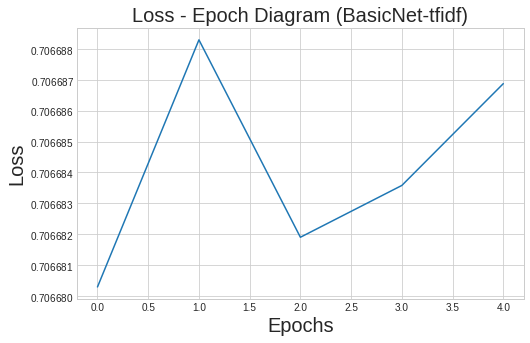

In [ ]:
loss_per_epoch(btrain_tfidf_ls, 'BasicNet-tfidf')

#### GloVe

In [ ]:
# initialize parameters
sample2=train_glove.shape[0] # the whole training set
epochs2=5
lr2=0.001
batch2=1024

# initialize Neural Net
net2 = BasicNet(train_glove.shape[1], train_glove.shape[1], 1)

In [ ]:
# train Neural Net
btrain_glove_ls = train_net(device, net2, train_glove, train_y, sample2, epochs2, lr2, batch2) 
# predict on test set
(bpred_glove,
 bnn_df.loc['BasicNet-glove','Precision'], 
 bnn_df.loc['BasicNet-glove','Recall'], 
 bnn_df.loc['BasicNet-glove','F1-Score']) = predict_on_test(device, net2, test_glove, test_y) 

epoch 1, loss 0.706683
epoch 2, loss 0.706684
epoch 3, loss 0.706684
epoch 4, loss 0.706682
epoch 5, loss 0.706692

Final loss 0.706692


**Our second experiment with BasicNet, using glove embeddings input vectors, produces more less the same results with our first experiment. Our model is overfitting, again. This means that pretrained embeddings can not change the efficiency of a whole model on their own. <br> We are obliged to make changes to BasicNet's layers and activations functions, in order to produce better results.**

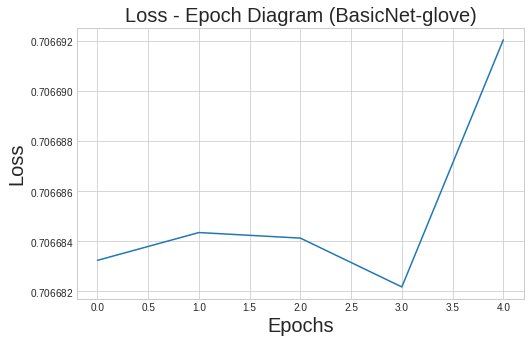

In [ ]:
loss_per_epoch(btrain_glove_ls, 'BasicNet-glove')

### BasicNet Prediction Evaluation

In [ ]:
bnn_df

,Precision,Recall,F1-Score
BasicNet-tfidf,50.048%,100.000%,66.709%
BasicNet-glove,50.048%,100.000%,66.709%


**Our first two experiments with BasicNet didn't provide us the results we would like, in terms of prediction on the test set. Examining the metrics at first glance, we may consider that the F1 Score seems satisfying. That's not entirely true because there is a big imbalance between the Precision and Recall metrics. This imbalance (Low Precision - High Recall) practically means that the Neural Network classifies all the positive sentiments correctly but it also classifies almost half of the negative sentiments as positive. As a result F1 Score gets a value between the values of Precision and Recall. However, this F1 Score value isn't representative of the effectiveness of the classifier, due to the fact that Precision is really bad. Another observation that is not so much expected is the fact that we get the same prediction results for both our models trained with different input vectors.**


### Neural Network (Upgraded Edition)

In [ ]:
class UpgradedNet(nn.Module):
  
  '''
    Upgraded Edition of our Feed-Forward Neural Net

    Structure:
      Linear input, hidden and output layers
      Use of LeakyReLu activation between every pair of layers to deal with the dying ReLU problem
    
    Output layer:
      Sigmoid activation function
  '''

  def __init__(self, input_dim, hidden_dim, output_dim):
    super(UpgradedNet, self).__init__()
        
    self.l1 = nn.Linear(input_dim, hidden_dim)
    self.relu1 = nn.LeakyReLU()                       # switch ReLu activation function with LeakyReLu activation function
    self.hd1 = (hidden_dim / 3) * 2 + 1               # calculate the number of output neurons of the first hidden layer        
    self.l2 = nn.Linear(hidden_dim, int(self.hd1)) 
    self.relu2 = nn.LeakyReLU()                       # switch ReLu activation function with LeakyReLu activation function
    self.hd2 = (int(self.hd1) / 3) * 2 + 1            # calculate the number of output neurons of the second hidden layer
    self.l3 = nn.Linear(int(self.hd1), int(self.hd2)) 
    self.relu3 = nn.LeakyReLU()                       # switch ReLu activation function with LeakyReLu activation function
    self.l4 = nn.Linear(int(self.hd2), output_dim)  
    
  def forward(self, X):
    out = self.l1(X)
    out = self.relu1(out)
    out = self.l2(out)
    out = self.relu2(out)
    out = self.l3(out)
    out = self.relu3(out)
    out = self.l4(out)    
    return F.sigmoid(out) # replace softmax of BasicNet with sigmoid

  def predict(self, X):
    Y_pred = self.forward(X)
    return Y_pred

In [ ]:
# function that trains a Neural Net and returns the loss history
# with manual implementation of Early Stopping and BCELoss loss function
def fit_with_early_stopping(net, train_X, train_y, epochs=10, learning_rate=0.1, batch_size=1, patience=3):
  not_improved = 0
  early_stop = False
  min_ls = np.Inf # initialize minimum loss
  
  train_ls = []
  train_iter = d2l.load_array((train_X, train_y), batch_size) # split train set in batches
  
  optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate) # AdaGrad Optimizer
  for epoch in range(epochs):
    epoch_ls = 0
    for X, y in train_iter:
      criterion = nn.BCELoss() # use BCELoss to calucalate the loss
      y = y.unsqueeze(1)
      l = criterion(net(X.float()), y) # calculate batch's loss
      epoch_ls += l.item() # sum all batches' losses of current epoch
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
    
    mean_ls = epoch_ls / len(train_iter) # calculate the mean loss of the current epoch
    mean_ls = round(mean_ls, 6) # round up the loss to the 6th decimal digit

    if mean_ls < min_ls: # store minimum loss
      not_improved = 0
      min_ls = mean_ls

    else:
      not_improved += 1 # raise not_improved counter

    if (epoch + 1) >= patience and not_improved == patience: # apply early stopping 
      print("Early stopping! (patience = " + str(patience) + ")")
      early_stop = True
      break

    print(f'epoch {epoch + 1}, loss {mean_ls:f}') 
    train_ls.append(mean_ls)

  return train_ls

# function that executes the Neural Net training and prints the loss per epoch, applying Early Stopping
def train_net_with_early_stopping(device, net, train_X, train_y, sample, epochs=10, lr=0.1, batch=1, patience=3):
  # add parameters to device
  train_X = train_X.to(device)
  train_y = train_y.to(device)
  net.to(device)

  # execute fit with Early Stopping on train set
  train_ls = fit_with_early_stopping(net, train_X[:sample], train_y[:sample], epochs=epochs, learning_rate=lr, batch_size=batch, patience=patience) 
  print(f'\nFinal loss {train_ls[-1]:f}')

  return train_ls 

In [ ]:
# function that executes prediction on test set using sigmoid activation function on output layer
def predict_on_test_with_sigmoid(device, net, test_X, test_y):
  # add parameters to device
  test_X = test_X.to(device)
  test_y = test_y.to(device)

  y_pred = net.predict(test_X) # execute predict on test set
  y_pred = y_pred.cpu().data.numpy() # convert to numpy
  
  y_pred = np.where(y_pred >= 0.5, 1, 0) # if prediction is >= 0.5 set it to 1

  test_y = test_y.cpu().data.numpy() # convert to numpy 

  prec = "%.3f%%" % (metrics.precision_score(test_y, y_pred) * 100)
  rec = "%.3f%%" % (metrics.recall_score(test_y, y_pred) * 100)
  f1 = "%.3f%%" % (metrics.f1_score(test_y, y_pred) * 100)

  return y_pred, prec, rec, f1

### Train & Predict

In [ ]:
# initialize dataframe to display metrics
unn_df = display_metrics('UpgradedNet-tfidf', 'UpgradedNet-glove')

In [ ]:
# enable gpu for faster execution
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


#### Tf-idf

In [ ]:
# initialize parameters
sample3=train_tfidf.shape[0] # the whole training set
epochs3=20
lr3=0.005
batch3=1024
patience=3 # number of allowed epochs with worse loss

# initialize Neural Net
net3 = UpgradedNet(train_tfidf.shape[1], train_tfidf.shape[1], 1)

In [ ]:
# train Neural Net
utrain_tfidf_ls = train_net_with_early_stopping(device, net3, train_tfidf, train_y, sample3, epochs3, lr3, batch3, patience) 
# predict on test set
(upred_tfidf,
 unn_df.loc['UpgradedNet-tfidf','Precision'], 
 unn_df.loc['UpgradedNet-tfidf','Recall'], 
 unn_df.loc['UpgradedNet-tfidf','F1-Score']) = predict_on_test_with_sigmoid(device, net3, test_tfidf, test_y) 

epoch 1, loss 0.590471
epoch 2, loss 0.586390
epoch 3, loss 0.585185
epoch 4, loss 0.584324
epoch 5, loss 0.583604
epoch 6, loss 0.583019
epoch 7, loss 0.582487
epoch 8, loss 0.582050
epoch 9, loss 0.581646
epoch 10, loss 0.581323
epoch 11, loss 0.580998
epoch 12, loss 0.580715
epoch 13, loss 0.580465
epoch 14, loss 0.580219
epoch 15, loss 0.580003
epoch 16, loss 0.579786
epoch 17, loss 0.579586
epoch 18, loss 0.579420
epoch 19, loss 0.579265
epoch 20, loss 0.579082

Final loss 0.579082


**We upgrade our first Neural network, BasicNet, into UpgradedNet. This time, we train UpgradedNet with BCELoss loss function and we use sigmoid activation function (appropriate for binary classification by default) in the output layer. We, also replace the ReLu activation functions with LeakyReLu ones. The reason we apply this change is related to the prediction results on the test set and we will analyze it below. Moreover, we choose the number of neurons in each hidden layer to be 2/3 the size of the neurons of the previous layer, plus the size of the output layer. The best learning rate that occured after experementation is 0.005, that's why we use it in both our UpgradedNet models. Finally, trying to avoid overfitting we train UpgradedNet with the Early Stopping technique, with patience=3 and after experementation it is indeed applied for a big number of epochs ( > 100). <br> In the above experiment we choose to train the model for 20 epochs to reduce time execution. Besides, the model already converges just fine and the loss is now reduced by more than 0.1 compared to the relative experiment we conducted with the BasicNet model. After executing the above experiment we can, in fact, confirm the bad effect of RMSE loss function in binary classification models. We know that MSE is not guaranteed to minimize the loss function, because MSE function expects real-valued inputs in range (-∞, ∞), while binary classification models output probabilities in range(0,1) through the sigmoid function. In a few words, RMSE was the main factor that caused overfitting in BasicNet models.  <br> The above results are visualized in the Loss-Epoch Diagram.**


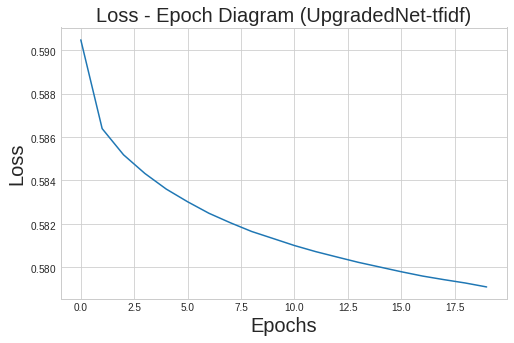

In [ ]:
loss_per_epoch(utrain_tfidf_ls, 'UpgradedNet-tfidf')

#### GloVe


In [ ]:
# initialize parameters
sample4=train_glove.shape[0] # the whole training set
epochs4=20
lr4=0.005
batch4=1024
patience=3 # number of allowed epochs with worse loss

# initialize Neural Net
net4 = UpgradedNet(train_glove.shape[1], train_glove.shape[1], 1)

In [ ]:
# train Neural Net
utrain_glove_ls = train_net_with_early_stopping(device, net4, train_glove, train_y, sample4, epochs4, lr4, batch4, patience) 
# predict on test set
(upred_glove,
 unn_df.loc['UpgradedNet-glove','Precision'], 
 unn_df.loc['UpgradedNet-glove','Recall'], 
 unn_df.loc['UpgradedNet-glove','F1-Score']) = predict_on_test_with_sigmoid(device, net4, test_glove, test_y) 

epoch 1, loss 0.561813
epoch 2, loss 0.545275
epoch 3, loss 0.539491
epoch 4, loss 0.535773
epoch 5, loss 0.533183
epoch 6, loss 0.531122
epoch 7, loss 0.529339
epoch 8, loss 0.527853
epoch 9, loss 0.526606
epoch 10, loss 0.525455
epoch 11, loss 0.524395
epoch 12, loss 0.523436
epoch 13, loss 0.522623
epoch 14, loss 0.521839
epoch 15, loss 0.521119
epoch 16, loss 0.520491
epoch 17, loss 0.519826
epoch 18, loss 0.519306
epoch 19, loss 0.518792
epoch 20, loss 0.518319

Final loss 0.518319


**Our second experiment with UpgradedNet, using glove embeddings input vectors, produces similar results with our previous experiment with UpgradedNet, concerning the loss. We train our model using the Early Stopping technique, with patience=3 and Early Stopping is again applied for a big number of epochs. In this experiment we also manage to avoid overfitting and we observe an even better loss reduction, since the loss is almost 0.2 lower compared to the relative loss of BasicNet model. The above results are visualized in the Loss-Epoch Diagram.**


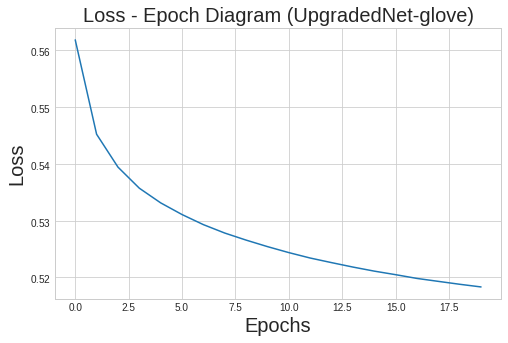

In [ ]:
loss_per_epoch(utrain_glove_ls, 'UpgradedNet-glove')

### UpgradedNet Prediction Evaluation

In [ ]:
unn_df

,Precision,Recall,F1-Score
UpgradedNet-tfidf,63.859%,77.412%,69.986%
UpgradedNet-glove,73.868%,73.475%,73.671%


**Our two experiments with UpgradedNet helped us optimize the results concerning the loss convergence. Specifically, we managed to stop overfitting and we reduced the loss by almost 15% in the first UpgradedNet model and by 30% in the second. Let's see what happened with the prediction on the test set. <br> At first glance, there is a significant improvement in the prediction results compared to the corresponding ones of our BasicNet models. After experementation, we concluded that the main reason that led to this improvement of the prediction results, is the use of the sigmoid function in the output layer combined with the changes we made in the hidden layers architecture. Let's break it down. <br> First of all, the switching of the output activation function from softmax to sigmoid had a big impact in loss reduction. More precisely, by using the sigmoid function the loss automatically dropped by 0.5 and the models began to converge normally. Another important factor, was the hidden layers architecture. The way we chose to gradually reduce the neurons layer by layer, led not only in faster loss convergence but also raised the prediction metrics by almost 4%. Continuing the analysis on model's architecture, the use of LeakyReLu activation function instead of ReLu had a small but significant effect in the metrics' values. We came up using LeakyReLu after experimenting with all respective activation functions like ReLu, ELU and SELU. LeakyReLu produced the best metrics among all of them by 2%. LeakyReLu turned out to have a good loss convergence even though it didn't converge faster than ReLu. ELU was a step behind concerning efficiency in both loss convergence and prediction metrics. Finally, SELU had a terrible convergence compared to the other 3 activation functions. <br> On the other hand, adding a dropout layer didn't have a good effect on the model. We tried putting a dropout layer in different positions of our Neural Network but in no case it had a positive impact. Specifically, the model was converging much slower and the metrics were similar with the ones of BasicNet. <br> Returning to the positive factors of prediction's improvment we should notice the importance of the size of input vectors. For example, at first we used tf-idf input vectors of size 100. The prediction results we got were worse than the BasicNet ones! Once, we changed the input size to 150 we noticed a huge raise of almost 10% on all metrics, that eventually led to the prediction results we show on the above dataframes. Last but not least, we should mention the importance of picking the correct optimizer. We already knew that theoretically AdaGrad is usually a good optimizer for binary classification problems. In order to be sure, we also, experimented with Stochastic Gradient Descent optimizer and the prediction results were very close to AdaGrad's, but the converge was much slower. Finally, we tried Adam optimizer as well and we observed a fast convergence. Yet, the prediction on the test set was much worse, since all metrics were almost 10% lower than metrics we got using AdaGrad.**


## Final Evaluation

#### Sort models from best to worst based on lowest Final Loss

In [ ]:
# initialize a dataframe to display loss
ls_df = display_func('BasicNet-tfidf', 'BasicNet-glove', 'UpgradedNet-tfidf', 'UpgradedNet-glove', 'Final-Loss')

# store each model's final loss 
ls_df.loc['BasicNet-tfidf','Final-Loss'] = btrain_tfidf_ls[-1]
ls_df.loc['BasicNet-glove','Final-Loss'] = btrain_glove_ls[-1]
ls_df.loc['UpgradedNet-tfidf','Final-Loss'] = utrain_tfidf_ls[-1]
ls_df.loc['UpgradedNet-glove','Final-Loss'] = utrain_glove_ls[-1]

# sort Neural Nets based on Final-Loss column
sort_ls_df = ls_df.sort_values(by=['Final-Loss'], ascending=True)
sort_ls_df

,Final-Loss
UpgradedNet-glove,0.518319
UpgradedNet-tfidf,0.579082
BasicNet-tfidf,0.706687
BasicNet-glove,0.706692


#### Sort models from best to worst based on highest F1 Score

In [ ]:
#concatenate dataframes' rows to create a new dataframe
nn_df = pd.concat([bnn_df, unn_df])

#sort Neural Nets based on F1-Score
sort_nn_df = nn_df.sort_values(by=['F1-Score'], ascending=False)
sort_nn_df

,Precision,Recall,F1-Score
UpgradedNet-glove,73.868%,73.475%,73.671%
UpgradedNet-tfidf,63.859%,77.412%,69.986%
BasicNet-tfidf,50.048%,100.000%,66.709%
BasicNet-glove,50.048%,100.000%,66.709%


#### Dominant Model

In [ ]:
sort_ls_df.head(2)

,Final-Loss
UpgradedNet-glove,0.518319
UpgradedNet-tfidf,0.579082


In [ ]:
sort_nn_df.head(2)

,Precision,Recall,F1-Score
UpgradedNet-glove,73.868%,73.475%,73.671%
UpgradedNet-tfidf,63.859%,77.412%,69.986%


**There is no doubt that our UpgradedNet Neural Network is far better than the BasicNet one. UpgradedNet is dominating BasicNet in every way. Not only it dealt with the overfitting problem and reduced the loss by almost 30% but it also led to a very trustworthy prediction on the test set. As we can see, there is a great balance between Pricison and Recall metrics, specially in the model, where glove embeddings are used. This balance leads to an equally great F1 Score, which is a determinant representative of a model's efficiency. <br> We chose to implement two totally contradictory models, in order to gradually present the changes we should make to reach a very satisfying result, as well as to emphasize the bad choices someone must avoid, so as not to be led to a frustrating result.**

### ROC Curve

**The Auc Score of UpgradedNet Neural Network, using pre-trained glove embeddings input vectors is ~80% and it's a decent score. As a matter of fact, the Auc Score is far better from the relative scores of the two BasicNet models and much better than the score of UpgradedNet, using tf-idf transformations as input vectors. The high Auc Score means that the model has a good ability at measuring how often a sentiment rating is correct.  We should be happy with our result, specially if we consider that Feed-Forward Neural Networks are, usually, good when classification is determined by a long range semantic dependency and they are not so effective at extracting local and position-invariant features. For tasks like Sentiment Analysis, where feature detection in text is more important (searching for angry terms, irony, sadness etc.), a Convolution Neural Network would surely produce the best results possible. <br> The Auc Score is visualized in the below ROC diagram, where the outcome is almost a perfect curve.**

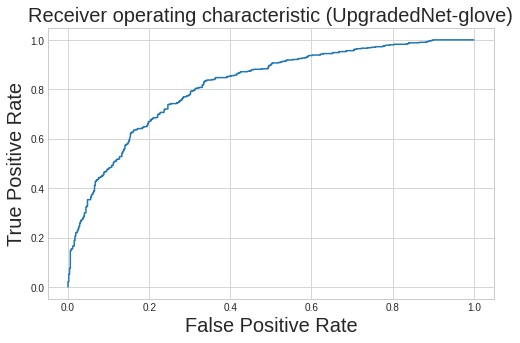


ROC Score =  81.573%


In [ ]:
# display the best ROC diagram based on Auc Score
roc_plot(net4, test_glove, test_y, batch4, 'UpgradedNet-glove')